# Import Libraries

In [2]:
import pyomo.environ as pyo
from pyomo.environ import *

# Introduction

Our project is based on a mathematical optimization model problem available on www.gurobi.com. We chose to translate gurobi code for "Supply Network Design I" into pyomo. The original problem and gurobi code is available at : https://www.gurobi.com/jupyter_models/supply-network-design/?fbclid=IwAR0WdxrqEs0zeFJqYd9V9j-K_N1HdXpJ_YQ8CvvFJyHYTynFfxaoAjRez0A. The purpose of this problem is to satisfy all customer demand while minimize the shipping cost.

In addition to code translation, we extend further to address the optimal location to set up a factory in order to serve the demand of the product based on the associated costs. In this part, we also use pyomo to help find the optimal solution. Finally, we introduce two methods, Newton and Nelder-Mead, to solve for a optimal product price to achieve maximum profit.

Our project is devided into 3 main parts:
1. Part 1: Translate gurobi code for "Supply Network Design I" into Pyomo.
2. Part 2: Optimize locations using Pyomo.
3. Part 3: Optimize price to get maximize profit. 

### Techniques applied

Techniques applied in this project are mainly (not in order):

Pyomo Model

Optimization (minimization: using Pyomo, Newton Method, and Nelder-Mead )

Mathematical programming


# Part 1: Translation from Gurobi to Pyomo on Supply Network Design I Problem

## The Model

The model tries to satisfy customer demand while minimizing its shipping costs. There are 6 customers and orders can be shipped either directly from the 2 factories or indirectly from the 4 transit points which receive the product from the factories. Demands of customers are given in the problem along with the shipping costs among the 3 parties. All transit points do not stock inventory i.e. all products shipped in will be shipped out. The factory's capacity has to cover the amount of product shipped out i.e. cannot shipped out more than what they can produce.

Information given in the problem:

Factories capacity:

| Factory | Supply (tons) |
| --- | --- |
| Liverpool | 150,000 |
| Brighton |  200,000 |

Depot throughput:

| Depot | Throughput (tons) |
| --- | --- |
| Newcastle | 70,000 |
| Birmingham | 50,000 |
| London | 100,000 |
| Exeter | 40,000 |

Customer Demand:

| Customer | Demand (tons) |
| --- | --- |
| C1 | 50,000 |
| C2 | 10,000 |
| C3 | 40,000 |
| C4 | 35,000 |
| C5 | 60,000 |
| C6 | 20,000 |

Shipping costs are in dollars per ton and details are in the table below:

Unavailable routes are indicated with "-"

| To | Liverpool | Brighton | Newcastle | Birmingham | London | Exeter |
| --- | --- | --- | --- | --- | --- | --- |
| **Depots** |
| Newcastle  | 0.5 |   - |
| Birmingham | 0.5 | 0.3 |
| London     | 1.0 | 0.5 |
| Exeter     | 0.2 | 0.2 |
| **Customers** |
| C1 | 1.0 | 2.0 |   - | 1.0 |   - |   - |
| C2 |   - |   - | 1.5 | 0.5 | 1.5 |   - |
| C3 | 1.5 |   - | 0.5 | 0.5 | 2.0 | 0.2 |
| C4 | 2.0 |   - | 1.5 | 1.0 |   - | 1.5 |
| C5 |   - |   - |   - | 0.5 | 0.5 | 0.5 |
| C6 | 1.0 |   - | 1.0 |   - | 1.5 | 1.5 |

**The objective is to find the lowest total shipping cost:**

Since the cost of shipping is in dollar per ton, we have to multiply the cost by the amount of product and sum them to achieve the total shipping cost.

\begin{equation}
\text{Minimize} \quad Z = \sum_{\text{Cities} \times \text{Cities}}{\text{cost}*\text{flow}}
\end{equation}

The given constraints are:

- **Factory output**: Flow of goods from a factory must not exceed maximum capacity of each factory.

\begin{equation}
\sum_{\text{Cities}}{\text{flow}_{fromFactories}} \leq \text{supply}
\end{equation}

- **Customer demand**: Flow of goods must meet all customer demand.

\begin{equation}
\sum_{\text{Cities}}{\text{flow}_{toCustomer}} = \text{demand}
\end{equation}

- **Depot flow**: Depot cannot stock products so inflow needs to equal outflow.

\begin{equation}
\sum_{\text{Cities}}{\text{flow}_{toDepot}} = 
\sum_{\text{Cities}}{\text{flow}_{fromDepot}}
\end{equation}

- **Depot capacity**: Flow into a depot must not exceed depot capacity.

\begin{equation}
\sum_{\text{Cities}}{\text{flow}_{toDepot}} \leq \text{through}
\end{equation}

## The Solution

The structure of the code is as follow:
1. Store information in dictionary
2. Set up a cost condition
2. Formulate the problem using m = ConcreteModel()
3. Define the control variables
4. Add the constraints
5. Set the objective function to minimize the total cost of shipping
6. Solve the model
7. Show and analyze result

## Python Implementation

In [3]:
#Create Dictionary
#Information on Factory Supply
Supply = {
    ('Liverpool'): 150000,
    ('Brighton'): 200000
}

#Information on Depot Capacity
Depot = {
    ('Newcastle'): 70000,
    ('Birmingham'): 50000,
    ('London'): 100000,
    ('Exeter'): 40000
}

#Customer Demand
Demand = {
    ('C1'): 50000,
    ('C2'): 10000,
    ('C3'): 40000,
    ('C4'): 35000,
    ('C5'): 60000,
    ('C6'): 20000
}

#Shipping Cost
Cost = {
    ('Liverpool','Newcastle'): 0.5,
    ('Liverpool','Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    ('Liverpool', 'C1'): 1.0,
    ('Liverpool', 'C3'): 1.5,
    ('Liverpool', 'C4'): 2.0,
    ('Liverpool', 'C6'): 1.0,
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,
    ('Brighton', 'C1'): 2.0,
    ('Newcastle', 'C2'): 1.5,
    ('Newcastle', 'C3'): 0.5,
    ('Newcastle', 'C5'): 1.5,
    ('Newcastle', 'C6'): 1.0,
    ('Birmingham', 'C1'): 1.0,
    ('Birmingham', 'C2'): 0.5,
    ('Birmingham', 'C3'): 0.5,
    ('Birmingham', 'C4'): 1.0,
    ('Birmingham', 'C5'): 0.5,
    ('London', 'C2'): 1.5,
    ('London', 'C3'): 2.0,
    ('London', 'C5'): 0.5,
    ('London', 'C6'): 1.5,
    ('Exeter', 'C3'): 0.2,
    ('Exeter', 'C4'): 1.5,
    ('Exeter', 'C5'): 0.5,
    ('Exeter', 'C6'): 1.5
}

In setting up a total cost condition, if a factory send products directly to customer the total cost of shipping is already given by the problem. If the products are sent indirectly via depot, the total cost of the shipping will be the cost from the factory to the depot and from the depot to the customer.

Since not all locations can sent out products to all customers, we create a higher shipping cost to avoid the solver picking those routes.

We merge 'Supply' and 'Depot' dictionary for the code to get cost information by looking up if the factory and the sender is from the same location or not.

In [4]:
Sender = dict(Supply)
Sender.update(Depot)

In [5]:
#Create condition for total transportation costs
Total_Cost = {}
for Factory_city in Supply.keys():
    for Sender_city in Sender.keys():
        for Customer_city in Demand.keys():
            if Factory_city == Sender_city:
                Total_Cost[(Factory_city, Sender_city, Customer_city)] = Cost.get((Sender_city, Customer_city),5000)
            else:
                Total_Cost[(Factory_city, Sender_city, Customer_city)] = Cost.get((Factory_city, Sender_city),5000) + Cost.get((Sender_city, Customer_city),5000)

In [6]:
#Create a model
m = ConcreteModel()

#Create initial elements, i for factories, j for senders, and k for customers
m.i = Set(initialize = Supply.keys(), doc = 'From Factory')
m.j = Set(initialize = Sender.keys(), doc = 'From Factory or Depot')
m.k = Set(initialize = Demand.keys(), doc = 'Customers')

#Create variable
m.x = Var(m.i,m.j,m.k, bounds = (0,None), doc = 'Transportation Flow')

#Create parameters
m.s = Param(m.i, initialize = Supply, doc = 'Factory Supply')
m.t = Param(m.j, initialize = Sender, doc = 'Through')
m.d = Param(m.k, initialize = Demand, doc = 'Customer Demand')
m.c = Param(m.i,m.j,m.k, initialize = Total_Cost, doc = 'Total Transportation Cost')

In [7]:
#Create Constraint
#Factory output constraint
def Supply_rule(m,i):
    return sum(m.x[i,j,k] for j in m.j for k in m.k) <= m.s[i]
m.Supply = Constraint(m.i, rule = Supply_rule, doc = 'Factory i max capacity')

#Customer demand constraint
def Demand_rule(m,k):
    return sum(m.x[i,j,k] for i in m.i for j in m.j) == m.d[k]
m.Demand = Constraint(m.k, rule = Demand_rule, doc = 'Customer j satisfied')

#Depot constraint
def Depot_rule(m,j):
        return sum(m.x[i,j,k] for i in m.i for k in m.k) <= m.t[j]
m.Cap = Constraint(m.j, rule = Depot_rule, doc = 'Depot j Capacity')

In [8]:
#Set objective
def Objective_rule(m):
    return sum(m.c[i,j,k]*m.x[i,j,k] for i in m.i for j in m.j for k in m.k)
m.obj = Objective(rule = Objective_rule, sense = minimize, doc = 'Objective function')

In [9]:
#Show results
SolverFactory('glpk').solve(m).write()

print("\nOptimal flows :")
if m.obj()>0:
    for i in m.i:
        for j in m.j:
            for k in m.k:
                print(j,'->',k,':', value(m.x[i,j,k]))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 198500.0
  Upper bound: 198500.0
  Number of objectives: 1
  Number of constraints: 15
  Number of variables: 73
  Number of nonzeros: 217
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02524399757385254
# ----------------------------------------------------------
#   Solution Information
# ---------------------------

## Analysis Part 1

In [10]:
#Display model
m.display()

Model unknown

  Variables:
    x : Transportation Flow
        Size=72, Index=x_index
        Key                               : Lower : Value   : Upper : Fixed : Stale : Domain
         ('Brighton', 'Birmingham', 'C1') :     0 :     0.0 :  None : False : False :  Reals
         ('Brighton', 'Birmingham', 'C2') :     0 : 10000.0 :  None : False : False :  Reals
         ('Brighton', 'Birmingham', 'C3') :     0 :     0.0 :  None : False : False :  Reals
         ('Brighton', 'Birmingham', 'C4') :     0 : 35000.0 :  None : False : False :  Reals
         ('Brighton', 'Birmingham', 'C5') :     0 :  5000.0 :  None : False : False :  Reals
         ('Brighton', 'Birmingham', 'C6') :     0 :     0.0 :  None : False : False :  Reals
           ('Brighton', 'Brighton', 'C1') :     0 :     0.0 :  None : False : False :  Reals
           ('Brighton', 'Brighton', 'C2') :     0 :     0.0 :  None : False : False :  Reals
           ('Brighton', 'Brighton', 'C3') :     0 :     0.0 :  None : False 

The lowest shipping cost is $198,500 and customer demands are met.

All constraints are satisfied.

1. The amount of product shipped out from each factory does not exceed that maximum capacity. Liverpool shipped out 70,000 tons while its maximum capacity is at 150,000 tons. Brighton shipped out 145,000 tons while its maximum capacity is at 200,000 tons.

2. Customers demand are fully met. Every customer received the amount of product as they desired.

3. The volume of product moving through each depot does not exceed its capacity. Birmingham receives 50,000 tons of product (maximum capacity 50,000 tons), Exetor receives 40,000 tons (maximum capacity 40,000 tons), and London receives 55,000 tons (maximum capacity 100,000 tons) We also noticed that all products shipped out from Liverpool goes directly to customers without going through any depots while all products from Brighton goes through depots before reaching end customers.

We also would like to note that in the process of soving the problem, we do not include the constraint to control the inflow and outflow of the depots. However, the result that we get does satisfy this constraint.

Since our project is to translate gurobi to pyomo, we compare the result obtained from both method and they give the same result for this problem. In addition, we found that using gurobi to solve this type of problem is more convenient. The lines of code using gurobi are more concise especially when solving a more complex problem that involves more variables and constraints.

# Part 2: Locations optimal 

## The Model

In this part, we want to seek for the optimal location(s) to build the factory in order to meet the demand of products for depots. 
- We set N as the option for factory location. 
- We set M as the demand of depots.
- D(n,m) represents the cost of shipping from factory N to Depot M.

If the factory N is selected, the binary variable y(N,M) will equal to 1 and if the factory N is not selected, then the binary variable y(N,M) will equal to 0.

The variable x(N,M) indicates the fraction between the demand from depot M that is served by factory N.

## Python Implementation

In [11]:
#Locations of factory
N = ['Liverpool', 'Brighton','Cambridge']

#Locations of depot
M = ['Newcastle','Birmingham','London','Exeter']

#Costs associate with shipping from factory N to depot M
D = {
    ('Liverpool', 'Newcastle'): 0.5,
    ('Liverpool', 'Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    
    ('Brighton', 'Newcastle'): 0.2,
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,
    
    ('Cambridge', 'Newcastle'): 0.3,
    ('Cambridge', 'Birmingham'): 0.1,
    ('Cambridge', 'London'): 0.2,
    ('Cambridge', 'Exeter'): 0.4 
}
# the number of the factory
NumberofFactory = 3

In [12]:
#Create the model in Pyomo
model = ConcreteModel()
model.Locations = N
model.Depots = M

#Create variables
model.x = Var(model.Locations, model.Depots, bounds=(0.0,1.0))
model.y = Var(model.Locations, within = Binary) #the locations need to be binary either 1 or 0 

In [13]:
#Create the objective to optimize the factory locations
model.obj = Objective(expr = sum(D[n,m]*model.x[n,m] for n in model.Locations for m in model.Depots))

In [14]:
#Create the constraints
model.single_x = ConstraintList()
for m in model.Depots:
    model.single_x.add(sum( model.x[n,m] for n in model.Locations ) == 1.0) # if the factory is selected to serve the depot, the binary variable = 1
    
model.bound_y = ConstraintList()
for n in model.Locations:
    for m in model.Depots:
        model.bound_y.add(model.x[n,m] <= model.y[n]) # (the demand of depot that served by factory 
                                                        #must respect factory capacity)
        
model.num_facilities = Constraint(expr=sum( model.y[n] for n in model.Locations ) <= NumberofFactory)# the number of optimal locations must be
                                                                                                        #respect the factory capacity )

In [14]:
#Show results
SolverFactory('glpk').solve(model).write()
print('Objective function = ', model.obj())

#when the location is selected, print out the result of the factory will serve the depots 
#and the percentage of the serving.
for a in model.Locations:
    if value(model.y[a]) == 1:
        print("Factory at",a, "serving:")
    else:
        continue
    for b in model.Depots:
        if value(model.x[a,b]) != 0:
            print("--->", b, "--- {}%".format(value(model.x[a,b])*100))
    print()
    
print()
print(' The Cost is  :',"$","%.2f" %value(model.obj),"per ton") # we want to check the cost of this optimal plan.
print()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.7
  Upper bound: 0.7
  Number of objectives: 1
  Number of constraints: 18
  Number of variables: 16
  Number of nonzeros: 40
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.05179095268249512
# ----------------------------------------------------------
#   Solution Information
# --------------------------------------

In [15]:
# this is another way to print out the results
SolverFactory('glpk').solve(model).write()
print('Objective function = ', model.obj())

#The objective function printed out the result = 0.7 
#if the value of the factory location is > 0.5, 
#the outcome will give us the best optimal solution of which factory should serve which depots.
for w in N:
    if value(model.y[w]) > 0.5: 
        Depots = [str(cl) for cl in M if value(model.x[w, cl]) > 0.5] 
        print(str(w)+" serves depots: "+str(Depots))
    else:
        print(str(w)+": do not choose the factory")

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 0.7
  Upper bound: 0.7
  Number of objectives: 1
  Number of constraints: 18
  Number of variables: 16
  Number of nonzeros: 40
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.05044198036193848
# ----------------------------------------------------------
#   Solution Information
# --------------------------------------

In [16]:
#This is a way to print out fully details of the model such as objective declarations, constraint declarations.
print("OPTIMIZATION MODEL DETAILS:")
print()
model.pprint()

OPTIMIZATION MODEL DETAILS:

6 Set Declarations
    bound_y_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
    single_x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   12 : {('Liverpool', 'Newcastle'), ('Liverpool', 'Birmingham'), ('Liverpool', 'London'), ('Liverpool', 'Exeter'), ('Brighton', 'Newcastle'), ('Brighton', 'Birmingham'), ('Brighton', 'London'), ('Brighton', 'Exeter'), ('Cambridge', 'Newcastle'), ('Cambridge', 'Birmingham'), ('Cambridge', 'London'), ('Cambridge', 'Exeter')}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any : 

## Analysis Part 2 

The model suggests that all 3 factories should be opened to serve the depots. Factory locates in Liverpool will serve demands from depot in Exeter. Factory locates in Brighton will serve demands from depot in Newcastle. Factory in Cambridge will serves demand fron depots in Birmingham and London. It shows the optimal solution at which factory should be opened and serve at which depots.

The result also gives us the information about the cost of this optimal problem.

The model also meets the constraints such as the number optimal of the factory must be respect to the factory capacity.

We think it is a nice model that is useful to apply in the real life in many areas such as when the company would like to plan where to open the factory to produce their products or where to choose the warehouse to store their products in order to serve the customer faster, more efficient and saving costs.

# Part 3 : Optimal Price 

## The Model 


Now we want to expand our project further by trying to solve one of the problems that many companies face. How to optimize the price to have maximimum profit? 

In part 1, we solve one of the firm's problem which is to minimize the cost. Now, we would like to maximize the firm's profit by applying a simple methodology in economic on how to optimize the price.

In this part, we introduce two methods, the Newton method and the Nelder-Mead method. We use the first-order derivative in Newton method while the Nelder-Mead method searches for optimal value without the use of the first-order derivative. Only function evaluations are required; therefore, we believe the presented model is a good choice to solve a simple minimization problem.

We use a set of random number to solve our problem. 

We set the profit function is        $ Profit $ = $Revenue $ - $Cost$

- The cost for shipping is 10,000,000 dollar
- There is an additional cost of 2550 dollar for every customer if they want to use our excellent services. 

- The function for unit sales based on the price

    $ Unit Sales  = 1,000,000 - 3500p $ where $p$ is price.
    
It means that when our company charge the customer for the cost, the amount of the customer demand will also change. The higher the price, the lower the demand. 

The problem : Which price should we offer to the customer to maximize our profit?

## Import Additional Libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import minimize

## Model Formulation 

**Revenue = Total Sales** 

$ Total Sales =     Unit Sales * price = (1,000,000-3500p)p   =     1,000,000p -  3500p^2 $

**Total cost**

$ Total Cost =       10,000,000 + 2550(1,000,000-3500p) =       - 8,925,000p + 2,560,000,000 $

**Profit** 

$ Profit $ = $Revenue $ - $Total Cost$

$
= 1,000,000p -  3500p^2- (-8,925,000p + 2,560,000,000)     =       -  3500p^2 + 9,925,000p - 2,560,000,000 $




## Python Implementation 

In [18]:
#Set random parameters for initializing the non linear optimization method 
x0 =  1000

In [19]:
# Define a Profit Quadratic Function
def profit1(p):
    return -1*(-3500*p**2 + 9925000*p - 2560000000)
def profit2(p):
    return -1*(-3500*2*p + 9925000) # taking the 1st derivative from profit function

In [20]:
# Optimization Method with Newton
optimization = opt.minimize(profit1,x0,method='Newton-CG',jac=profit2)
print('Optimization of Newton Method is :',optimization)

Optimization of Newton Method is :      fun: array([-4.47611607e+09])
     jac: array([-0.])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 0
     nit: 2
    njev: 3
  status: 0
 success: True
       x: array([1417.85714286])


In [21]:
# Optimization Method with Nelder-Mead                          
optimization = minimize(profit1, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})
print('Optimization of Nelder-Mead Method is: ', optimization)

Optimization of Nelder-Mead Method is:   final_simplex: (array([[1417.85714328],
       [1417.85714329]]), array([-4.47611607e+09, -4.47611607e+09]))
           fun: -4476116071.428573
       message: 'Optimization terminated successfully.'
          nfev: 86
           nit: 38
        status: 0
       success: True
             x: array([1417.85714328])


In [22]:
# Results Display
print ("Optimal Price :", "$ "+str(optimization.x[0]))
print ("Maximum Profit:", "$ " +str(-1*profit1(optimization.x[0])))

Optimal Price : $ 1417.8571432828903
Maximum Profit: $ 4476116071.428573


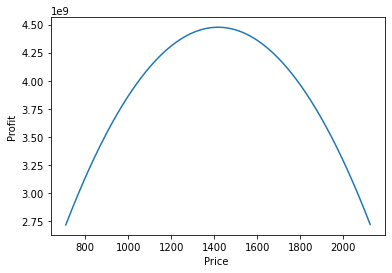

In [23]:
# Plot the profit and price to see the optimal solution 
r = [i for i in np.arange(optimization.x[0]-(optimization.x[0]/2),optimization.x[0]+(optimization.x[0]/2),1)]
plt.plot(r, [-profit1(j) for j in r])
plt.xlabel('Price ')
plt.ylabel('Profit')
plt.show()

## Analysis Part 3

In this part, we define the profit quadratic function to find the maximimum profit that the company can gain. By applying 2 optimization methods (Newton and Nelder-Mead) to find the optimal price that the company should use to maximize their profit. 

The two methods give the same result of the optimal prize at 1,417 dollar and the the maximum profit with given optimal price is 4,476,116,071 dollar. 

In the graph above, the x-axis represents the price and the y-axis represents the profit. The graph indicates that at the peak of the price, maximum profit is achieved. 

We found that this model is easy and simple to understand. By applying the above-mentioned methods, we can find the optimal value without complex computing procedure, Python computed the result within milliseconds. We believe that this model can be apply in real world when the company would like to know which price should they use in order to maximize their profit. 